# Scraping Capitol Trades


## Import Modules

In [65]:
import pandas as pd  # For handling data in DataFrame
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, r2_score, accuracy_score, roc_auc_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tbats import TBATS
from scipy import stats

### Set Up Paths

In [66]:
home_path = os.getcwd()
home_path = os.path.dirname(home_path)
home_path += "\\"

data_path = home_path + "02 Data Files\\"

print(data_path)

c:\Users\rjrul\OneDrive - University of Iowa\00 Current Semester\01 BAIS 3250 - Data Wrangling\05 Final Project\02 Data Files\


## Import Data

In [67]:
df = pd.read_csv(data_path+"04 YFinance\\"+"trade_comparison_yfinance.csv")

df

,Name,Ticker,Party,Chamber,State,Buy Date,Sell Date,Buy Price,Sell Price,Trade Return %,Market Buy Price,Market Sell Price,Market Return %,Overperformance %
0,Bill Keating,ABNB,Democrat,House,MA,2023-1-17,2024-5-16,99.915001,147.190002,47.315219,3999.280029,5297.100098,32.451343,14.863876
1,Bill Keating,BA,Democrat,House,MA,2023-9-14,2024-2-7,209.139999,211.919998,1.329253,4487.779785,4995.060059,11.303591,-9.974338
2,Bill Keating,BAC,Democrat,House,MA,2024-1-17,2024-9-10,30.738856,38.817738,26.282310,4739.129883,5495.520020,15.960528,10.321783
3,Bill Keating,GM,Democrat,House,MA,2023-6-26,2024-9-10,35.371884,44.605568,26.104586,4344.839844,5495.520020,26.483834,-0.379248
4,Bill Keating,GOOGL,Democrat,House,MA,2023-2-12,2024-5-16,94.995828,173.351212,82.482973,4068.919922,5297.100098,30.184427,52.298546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,Virginia Foxx,FLNG,Republican,House,NC,2023-1-3,2024-12-5,26.912435,22.639999,-15.875322,3853.290039,6075.109863,57.660332,-73.535654
1352,Virginia Foxx,MO,Republican,House,NC,2023-1-16,2024-1-9,37.561198,37.866795,0.813598,3960.600098,4756.500000,20.095437,-19.281839
1353,Virginia Foxx,PAA,Republican,House,NC,2023-3-23,2023-10-2,10.383142,13.596812,30.950851,3959.209961,4288.390137,8.314289,22.636562
1354,Virginia Foxx,T,Republican,House,NC,2023-1-31,2024-12-5,17.820059,23.531321,32.049620,4020.850098,6075.109863,51.090185,-19.040565


In [68]:
df['Buy Date'] = pd.to_datetime(df['Buy Date'])
df['Sell Date'] = pd.to_datetime(df['Sell Date'])

df["Days Held"] = np.where((df['Sell Date'] - df['Buy Date']).dt.days < 0, 0, (df['Sell Date'] - df['Buy Date']).dt.days)

df

,Name,Ticker,Party,Chamber,State,Buy Date,Sell Date,Buy Price,Sell Price,Trade Return %,Market Buy Price,Market Sell Price,Market Return %,Overperformance %,Days Held
0,Bill Keating,ABNB,Democrat,House,MA,2023-01-17,2024-05-16,99.915001,147.190002,47.315219,3999.280029,5297.100098,32.451343,14.863876,485
1,Bill Keating,BA,Democrat,House,MA,2023-09-14,2024-02-07,209.139999,211.919998,1.329253,4487.779785,4995.060059,11.303591,-9.974338,146
2,Bill Keating,BAC,Democrat,House,MA,2024-01-17,2024-09-10,30.738856,38.817738,26.282310,4739.129883,5495.520020,15.960528,10.321783,237
3,Bill Keating,GM,Democrat,House,MA,2023-06-26,2024-09-10,35.371884,44.605568,26.104586,4344.839844,5495.520020,26.483834,-0.379248,442
4,Bill Keating,GOOGL,Democrat,House,MA,2023-02-12,2024-05-16,94.995828,173.351212,82.482973,4068.919922,5297.100098,30.184427,52.298546,459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,Virginia Foxx,FLNG,Republican,House,NC,2023-01-03,2024-12-05,26.912435,22.639999,-15.875322,3853.290039,6075.109863,57.660332,-73.535654,702
1352,Virginia Foxx,MO,Republican,House,NC,2023-01-16,2024-01-09,37.561198,37.866795,0.813598,3960.600098,4756.500000,20.095437,-19.281839,358
1353,Virginia Foxx,PAA,Republican,House,NC,2023-03-23,2023-10-02,10.383142,13.596812,30.950851,3959.209961,4288.390137,8.314289,22.636562,193
1354,Virginia Foxx,T,Republican,House,NC,2023-01-31,2024-12-05,17.820059,23.531321,32.049620,4020.850098,6075.109863,51.090185,-19.040565,674


## Univariate

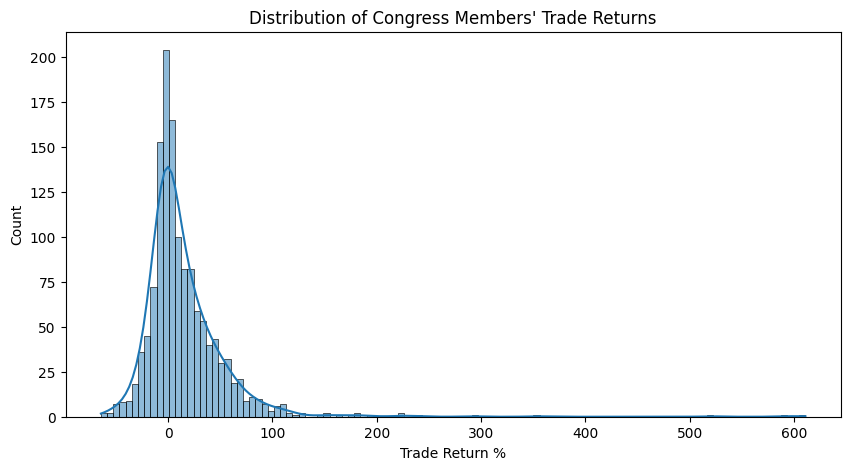

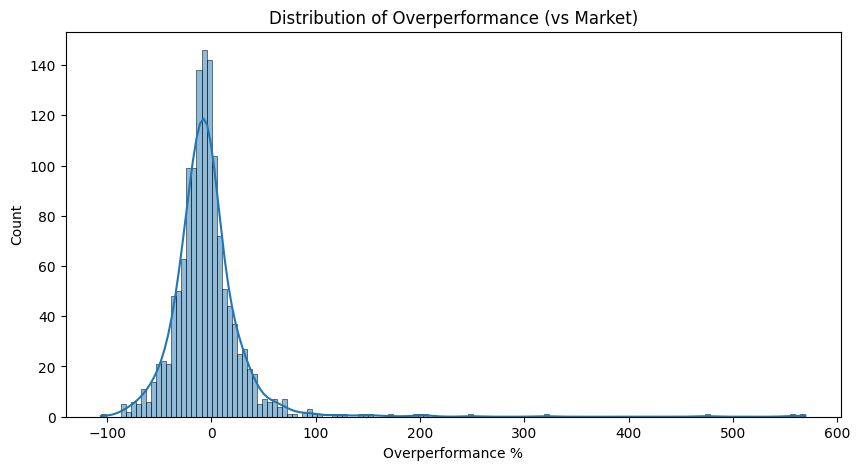

In [69]:
# Quick look at distribution
plt.figure(figsize=(10,5))
sns.histplot(df['Trade Return %'], kde=True)
plt.title('Distribution of Congress Members\' Trade Returns')
plt.xlabel('Trade Return %')
plt.savefig(data_path+"05 Analysis\\01 Graphs\\"+'Distribution_of_Returns.png', dpi=300)
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df['Overperformance %'], kde=True)
plt.title('Distribution of Overperformance (vs Market)')
plt.xlabel('Overperformance %')
plt.savefig(data_path+"05 Analysis\\01 Graphs\\"+'Distribution_Of_Overperformance.png', dpi=300)
plt.show()

In [70]:
df["Trade Return %"].describe()

count    1356.000000
mean       15.381012
std        43.785024
min       -64.497670
25%        -5.537237
50%         4.962183
75%        27.510816
max       610.853201
Name: Trade Return %, dtype: float64

In [71]:
df["Overperformance %"].describe()

count    1355.000000
mean       -4.039460
std        40.507125
min      -105.954546
25%       -20.918172
50%        -7.151286
75%         5.779736
max       569.396325
Name: Overperformance %, dtype: float64

## Bivariate

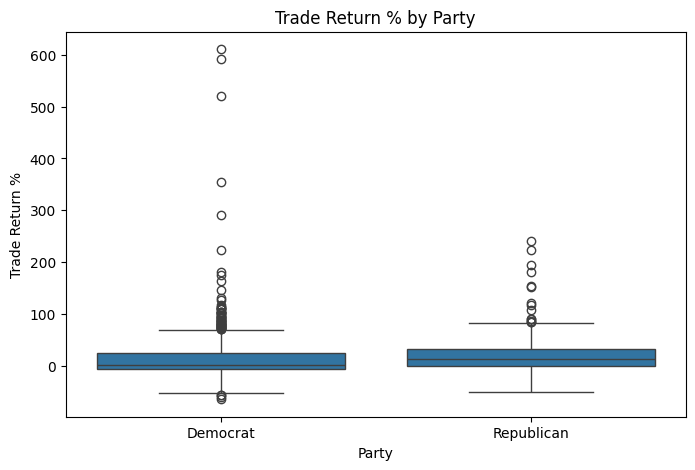

In [72]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Party', y='Trade Return %', data=df)
plt.title('Trade Return % by Party')
plt.savefig(data_path+"05 Analysis\\01 Graphs\\"+'Trade_Return_by_Party.png', dpi=300)
plt.show()

In [73]:
df.groupby('Party')['Trade Return %'].describe()

,count,mean,std,min,25%,50%,75%,max
Party,,,,,,,,
Democrat,947.0,13.595636,47.307700,-64.497670,-7.020651,2.313267,23.904776,610.853201
Republican,409.0,19.514879,33.959877,-50.320446,-0.969316,14.068503,32.591542,241.573284


In [74]:
df.groupby('Party')['Trade Return %'].describe().to_clipboard()

In [75]:
df.groupby('Chamber')['Trade Return %'].describe()

,count,mean,std,min,25%,50%,75%,max
Chamber,,,,,,,,
House,1215.0,15.216521,44.310606,-64.497670,-5.540909,4.702638,27.324489,610.853201
Senate,141.0,16.798436,39.077666,-52.603882,-5.315478,8.375033,31.038886,223.453015


In [76]:
df.groupby('Chamber')['Trade Return %'].describe().to_clipboard()

## Hypothesis Test

In [77]:
def test_run(data1, data2=0, type="T1samp", tests=["Greater", "Less", "Different"]):
    testdict = {}
    alts = ['greater', 'less', 'two-sided']
    n = -1
    for i, test in enumerate(tests):
        n += 1
        trialdict = {}
        if type == "T1samp":
            t_stat, p_value = stats.ttest_1samp(data1, data2, alternative=alts[i])
        elif type == "TInd":
            t_stat, p_value = stats.ttest_ind(data1, data2, equal_var=False, alternative=alts[i])
        else: return None
        result = .05 > p_value
        trialdict['Test'] = test
        trialdict['P_Val'] = p_value
        trialdict["Result"] = result
        testdict[n] = trialdict
    result_df = pd.DataFrame.from_dict(testdict, orient='Index').reset_index(drop=True)
    return result_df

In [78]:
tests = ["Congress members' returns overperform the market at a statistically significant level", 
         "Congress members' returns underperform the market at a statistically significant level", 
         "Congress members' returns perform differently than the market at a statistically significant level"]

results_market = test_run(df['Overperformance %'].dropna(), type="T1samp", tests=tests)

In [79]:
tests = ["Democrat Congress Members outperform Republican Congress Members in the stock market at a statistically significant level.",
         "Democrat Congress Members underperform Republican Congress Members in the stock market at a statistically significant level.",
         "Democrat Congress Members's returns are different than Republican Congress Members' returns in the stock market at a statistically significant level."]

dfsub = df.dropna(subset=['Trade Return %', 'Party'])

dems = dfsub[dfsub['Party'] == 'Democrat']['Trade Return %']
reps = dfsub[dfsub['Party'] == 'Republican']['Trade Return %']

results_party = test_run(dems, reps, type='TInd', tests=tests)

In [80]:
tests = ["Congress Members who serve in the Senate outperform Congress Members who serve in the House in the stock market at a statistically significant level.",
         "Congress Members who serve in the Senate underperform Congress Members who serve in the House in the stock market at a statistically significant level.",
         "Congress Members who serve in the Senate's returns are different than Congress Members who serve in the House's returns in the stock market at a statistically significant level."]

dfsub = df.dropna(subset=['Trade Return %', 'Chamber'])

house = dfsub[dfsub['Chamber'] == 'House']['Trade Return %']
senate = dfsub[dfsub['Chamber'] == 'Senate']['Trade Return %']

results_chamber = test_run(senate, house, type='TInd', tests=tests)

In [81]:
results = pd.concat([results_market,results_party, results_chamber]).reset_index(drop=True)

results.to_csv(data_path+"05 Analysis\\"+"hypothesis_test_results.csv", index=False)

results

,Test,P_Val,Result
0,Congress members' returns overperform the mark...,0.999874,False
1,Congress members' returns underperform the mar...,0.000126,True
2,Congress members' returns perform differently ...,0.000251,True
3,Democrat Congress Members outperform Republica...,0.995274,False
4,Democrat Congress Members underperform Republi...,0.004726,True
5,Democrat Congress Members's returns are differ...,0.009452,True
6,Congress Members who serve in the Senate outpe...,0.327196,False
7,Congress Members who serve in the Senate under...,0.672804,False
8,Congress Members who serve in the Senate's ret...,0.654392,False


In [82]:
results.iloc[7:].to_clipboard()

## Machine Learning

In [83]:
df['Overperformed'] = (df['Overperformance %'] > 0).astype(int)

X = pd.get_dummies(df[['Party', 'Chamber', "State"]], drop_first=True)
X['Days Held'] = df['Days Held']
y = df['Overperformed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:

model_name = 'Random Forest'
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred,zero_division=0,output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.reset_index()
report_df = report_df.rename(columns={'index':'Level'})
report_df['Model'] = model_name
report_df = report_df[['Model'] + [col for col in report_df.columns if col != 'Model']]

In [85]:
model_name = 'Decision Tree'
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred,zero_division=0,output_dict=True)
tempdf = pd.DataFrame(report).transpose()
tempdf = tempdf.reset_index()
tempdf = tempdf.rename(columns={'index':'Level'})
tempdf['Model'] = model_name
tempdf = tempdf[['Model'] + [col for col in tempdf.columns if col != 'Model']]
report_df = pd.concat([report_df,tempdf]).reset_index(drop=True)

In [86]:
model_name = 'Logistic Regression'
model = LogisticRegression(random_state=42, max_iter=10000)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred,zero_division=0,output_dict=True)
tempdf = pd.DataFrame(report).transpose()
tempdf = tempdf.reset_index()
tempdf = tempdf.rename(columns={'index':'Level'})
tempdf['Model'] = model_name
tempdf = tempdf[['Model'] + [col for col in tempdf.columns if col != 'Model']]
report_df = pd.concat([report_df,tempdf]).reset_index(drop=True)

In [87]:
report_df.to_csv(data_path+"05 Analysis\\"+"ML_Classifier_Results.csv", index=False)
report_df.to_clipboard()
display(report_df)

,Model,Level,precision,recall,f1-score,support
0,Random Forest,0,0.675676,0.862069,0.757576,174.000000
1,Random Forest,1,0.520000,0.265306,0.351351,98.000000
2,Random Forest,accuracy,0.647059,0.647059,0.647059,0.647059
3,Random Forest,macro avg,0.597838,0.563688,0.554464,272.000000
4,Random Forest,weighted avg,0.619587,0.647059,0.611215,272.000000
5,Decision Tree,0,0.680180,0.867816,0.762626,174.000000
6,Decision Tree,1,0.540000,0.275510,0.364865,98.000000
7,Decision Tree,accuracy,0.654412,0.654412,0.654412,0.654412
8,Decision Tree,macro avg,0.610090,0.571663,0.563746,272.000000
9,Decision Tree,weighted avg,0.629674,0.654412,0.619315,272.000000


In [88]:
report_df.to_clipboard()

## Forecasting - Buy Side

In [89]:
volume_df = df[["Buy Date"]]
volume_df["Buy Date"] = volume_df["Buy Date"].dt.to_period('M')
volume_df = volume_df.sort_values("Buy Date").reset_index(drop=False)
volume_df = volume_df.groupby("Buy Date").count()
volume_df = volume_df.rename(columns={'index':'Trades'})
volume_df = volume_df.reset_index()
volume_df['Buy Date'] = volume_df['Buy Date'].dt.to_timestamp()  # convert Period to Timestamp
volume_df = volume_df.set_index('Buy Date')
volume_df

C:\Users\rjrul\AppData\Local\Temp\ipykernel_25324\2730065587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volume_df["Buy Date"] = volume_df["Buy Date"].dt.to_period('M')


,Trades
Buy Date,
2023-01-01,223
2023-02-01,96
2023-03-01,94
2023-04-01,105
2023-05-01,45
2023-06-01,33
2023-07-01,28
2023-08-01,28
2023-09-01,111


In [90]:
volume_df.to_clipboard()

In [91]:
ma4 = volume_df['Trades'].rolling(window=4).mean()
ma6 = volume_df['Trades'].rolling(window=6).mean()
ses_08 = SimpleExpSmoothing(volume_df['Trades']).fit(smoothing_level=0.8)
ses_02 = SimpleExpSmoothing(volume_df['Trades']).fit(smoothing_level=0.2)
hw_additive = ExponentialSmoothing(volume_df['Trades'], trend='add', seasonal='add', seasonal_periods=12).fit()
hw_multiplicative = ExponentialSmoothing(volume_df['Trades'], trend='add', seasonal='mul', seasonal_periods=12).fit()

estimator = TBATS(seasonal_periods=[12], use_arma_errors=True, use_box_cox=False, use_trend=True)
model_tbats = estimator.fit(volume_df['Trades'])
forecast_tbats = model_tbats.forecast(steps=6)

C:\Users\rjrul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rjrul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
C:\Users\rjrul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rjrul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0

In [92]:
train = volume_df.loc[:'2024-07-01']
test = volume_df.loc['2024-07-01':'2024-12-01']

forecast_ma4 = ma4.loc[test.index]
forecast_ma6 = ma6.loc[test.index]
forecast_ses_08 = ses_08.fittedvalues.loc[test.index]
forecast_ses_02 = ses_02.fittedvalues.loc[test.index]
forecast_hw_add = hw_additive.fittedvalues.loc[test.index]
forecast_hw_mul = hw_multiplicative.fittedvalues.loc[test.index]
forecast_tbats = forecast_tbats

# Calculate MAE
mae_results = pd.DataFrame({
    'Forecasting Technique': ['Moving Average (n=4)', 'Moving Average (n=6)', 'SES (alpha=0.8)', 'SES (alpha=0.2)', 
               'HW Additive', 'HW Multiplicative', 'TBATS'],
    'MAE': [
        mean_absolute_error(test['Trades'], forecast_ma4),
        mean_absolute_error(test['Trades'], forecast_ma6),
        mean_absolute_error(test['Trades'], forecast_ses_08),
        mean_absolute_error(test['Trades'], forecast_ses_02),
        mean_absolute_error(test['Trades'], forecast_hw_add),
        mean_absolute_error(test['Trades'], forecast_hw_mul),
        mean_absolute_error(test['Trades'], forecast_tbats)
    ]
})

# Sort by MAE
mae_results = mae_results.sort_values('MAE').reset_index(drop=True)
mae_results

,Forecasting Technique,MAE
0,Moving Average (n=4),4.125000
1,SES (alpha=0.8),4.439151
2,Moving Average (n=6),5.416667
3,HW Multiplicative,6.033796
4,SES (alpha=0.2),23.562934
5,HW Additive,40.164742
6,TBATS,66.380817


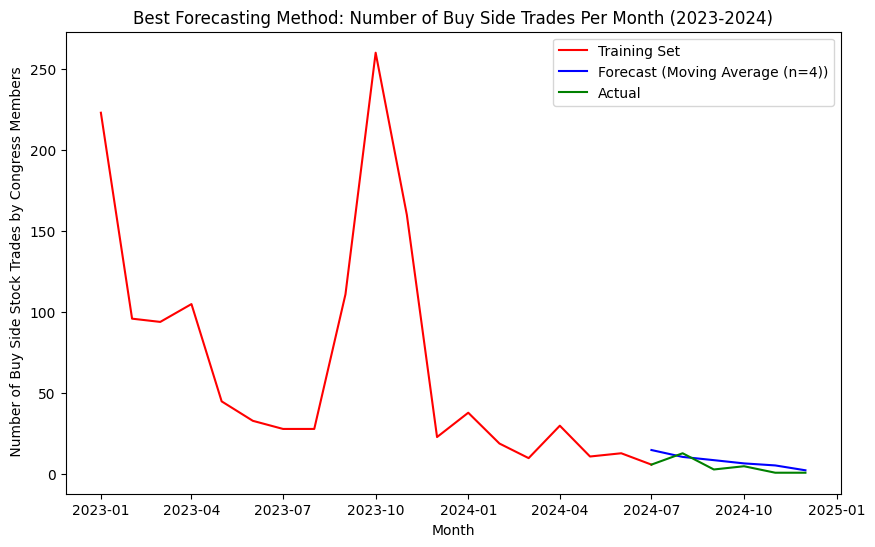

In [94]:
best_method = mae_results.iloc[0]['Forecasting Technique']

# Select the best forecast for the period 2016-2018
if best_method == 'Moving Average (n=4)':
    best_forecast = forecast_ma4
elif best_method == 'Moving Average (n=6)':
    best_forecast = forecast_ma6
elif best_method == 'SES (alpha=0.8)':
    best_forecast = forecast_ses_08
elif best_method == 'SES (alpha=0.2)':
    best_forecast = forecast_ses_02
elif best_method == 'HW Additive':
    best_forecast = forecast_hw_add
elif best_method == 'HW Multiplicative':
    best_forecast = forecast_hw_mul
elif best_method == 'TBATS':
    best_forecast = forecast_tbats

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Trades'], color='red', label='Training Set')
plt.plot(test.index, best_forecast, color='blue', label=f'Forecast ({best_method})')
plt.plot(test.index, test['Trades'], color='green', label=f'Actual')
plt.title('Best Forecasting Method: Number of Buy Side Trades Per Month (2023-2024)')
plt.xlabel('Month')
plt.ylabel(' Number of Buy Side Stock Trades by Congress Members')
plt.legend()
plt.savefig(data_path+"05 Analysis\\01 Graphs\\"+'Volume_Forecasting_Buy_Side.png', dpi=300)
plt.show()